In [ ]:
!pip install datasets tqdm pandas matplotlib langchain sentence_transformers  langchain-community torch accelerate fastapi pyngrok

: 

In [2]:
pip install faiss-gpu==1.7.4+cu116 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement faiss-gpu==1.7.4+cu116 (from versions: none)
ERROR: No matching distribution found for faiss-gpu==1.7.4+cu116


In [3]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 53.9 MB/s eta 0:00:00


In [4]:
!pip install datasets

In [5]:
import pandas as pd
from tqdm.notebook import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
pd.set_option("display.max_colwidth", None)
fp = open("/content/sample_data/data.txt", "r")
s = fp.read().split("\n\n\n\n")
fp.close()
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc)
    for doc in tqdm(s)
]

#Knowledge Base Creation:

# Splitting a large file into smaller text blocks, where each block represents a document.
# Wrapping each document as a LangchainDocument, which can later be used with LangChain for tasks like:

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

  0%|          | 0/618 [00:00<?, ?it/s]

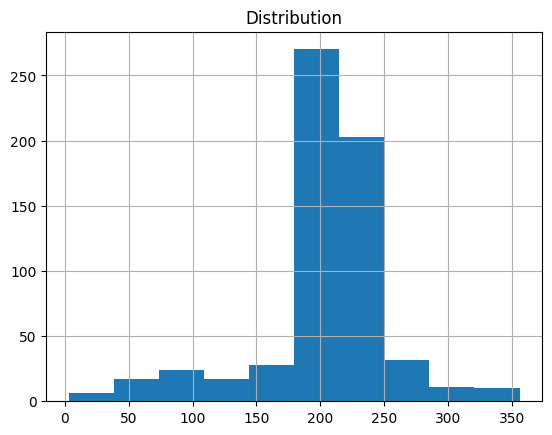

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
MARKDOWN_SEPARATORS = [
    "\n#{1,6}",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n__+\n",
    "\n\n",
    "\n",
    " ",
    ""
]
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)
docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
fig.set_title("Histogram of Document Lengths")
plt.title("Distribution")
plt.show()

In [7]:
from typing import Optional, List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
def split_documents(
        chunk_size: int,
        knowledge_base: list[LangchainDocument],
        tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> list[LangchainDocument]:
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)
    return docs_processed_unique
docs_processed = split_documents(512, RAW_KNOWLEDGE_BASE, tokenizer_name=EMBEDDING_MODEL_NAME)
print(len(docs_processed))
print(docs_processed[0:3])

297
[Document(metadata={'start_index': 0}, page_content='A Step by Step Guide for E-filing\n(For High courts & District Courts of India )\n1.1.Introduction\nWelcome to the digital world of E-filing of High courts /District courts of India and this userWelcome\nto the digital world of E-filing of High courts /District courts of India and this user\nguide will help you with step by step how to efile your case in the online efiling portal.guide will help\nyou with step by step how to efile your case in the online efiling portal.\nFollow this step by step guide and Start E-filing your cases from the comfort of your OfficeFollow this\nstep by step guide and Start E-filing your cases from the comfort of your Office\nand And join the new band ofand And join the new band of DIGITAL ERA ADDIGITAL ERA ADVOCATE\n.VOCATE .\n1.2.Getting Started\n●● Before starting efiling confirm and ensure the following details:Before starting efiling confirm and\nensure the following details:\n●● You must be a re

In [8]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import torch
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed,
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

/tmp/ipython-input-48476698.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.manual_seed(0)  # Set random seed for reproducibility

# Load model
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map="cpu",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

# Create pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

# Generation settings
generation_args = {
    "max_new_tokens": 500,
    "do_sample": False,
}


config.json: 0.00B [00:00, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Device set to use cpu


In [12]:
# prompt_chat = [
#     {
#         "role": "system",
#         "content": """Using the information contained in the context,
# Give a comprehensive answer to the question.
# Respond only to the question asked, response should be concise and relevant to the question.
# provide the number of the source document when relevant.
# If the answer cannot be deduced from the context, do not give an answer""",
#     },
#     {
#         "role": "user",
#         "content": """Context:
# {context}
# ---
# Now here is the Question you need to answer.
# Question:{question}""",
#     },
# ]
# RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
#     prompt_chat, tokenize=False, add_generation_prompt=True,
# )
# print(RAG_PROMPT_TEMPLATE)

prompt_chat = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
Give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.
Only generate a CSV-formatted table if the user explicitly asks for it.
Do not provide any table unless the user specifically requests it. If no table is requested, give a simple, clear, and concise answer in plain text."""
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the Question you need to answer.
Question:{question}
If you need to return a table, please provide the response in CSV format with column headers and comma-separated values."""
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_chat, tokenize=False, add_generation_prompt=True,
)
print(RAG_PROMPT_TEMPLATE)


<|system|>
Using the information contained in the context,
Give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.
Only generate a CSV-formatted table if the user explicitly asks for it.
Do not provide any table unless the user specifically requests it. If no table is requested, give a simple, clear, and concise answer in plain text.<|end|>
<|user|>
Context:
{context}
---
Now here is the Question you need to answer.
Question:{question}
If you need to return a table, please provide the response in CSV format with column headers and comma-separated values.<|end|>
<|assistant|>



In [15]:
from transformers import pipeline

# ✅ Use a smaller model that runs much faster
pipe = pipeline(
    "text-generation",
    model="microsoft/phi-3-mini-4k-instruct",
    device_map="auto",       # use GPU if available, CPU otherwise
)

u_query = "give me steps for e-filing in table form"

# Retrieve top 3 similar documents
retrieved_docs_with_scores = KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score(query=u_query, k=3)

print("======================================\n")
for i in retrieved_docs_with_scores:
    print(i)
    print()
print("======================================\n")

# Separate documents and scores
retrieved_docs = [doc for doc, score in retrieved_docs_with_scores]
similarity_scores = [score for doc, score in retrieved_docs_with_scores]
print("\nSimilarity scores of the retrieved documents:", similarity_scores)

# Define score range
threshold_lower = 0.155
threshold_upper = 0.349
score_within_range = any(threshold_lower <= score <= threshold_upper for score in similarity_scores)

if score_within_range:
    context = retrieved_docs[0].page_content[:1000]  # shorter context for speed
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=u_query, context=context)

    # ⚡ Fast, light generation settings
    output = pipe(
        final_prompt,
        max_new_tokens=150,
        truncation=True,
        return_full_text=False,
        do_sample=False,
        use_cache=False
    )

    print("\nAnswer found within the specified score range:")
    print("YOUR QUESTION:\n", u_query, "\n")
    print("FAST MODEL ANSWER:\n", output[0]['generated_text'])

else:
    print("\nYour question is not found in the dataset.")


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



(Document(id='71dfa7c5-0668-4d67-9a39-bcc4882d334c', metadata={'start_index': 0}, page_content='A Step by Step Guide for E-filing\n(For High courts & District Courts of India )\n1.1.Introduction\nWelcome to the digital world of E-filing of High courts /District courts of India and this userWelcome\nto the digital world of E-filing of High courts /District courts of India and this user\nguide will help you with step by step how to efile your case in the online efiling portal.guide will help\nyou with step by step how to efile your case in the online efiling portal.\nFollow this step by step guide and Start E-filing your cases from the comfort of your OfficeFollow this\nstep by step guide and Start E-filing your cases from the comfort of your Office\nand And join the new band ofand And join the new band of DIGITAL ERA ADDIGITAL ERA ADVOCATE\n.VOCATE .\n1.2.Getting Started\n●● Before starting efiling confirm and ensure the following details:Before starting efiling confirm and\nensure the

In [24]:
!ngrok config add-authtoken 34ahldRD96ygLgXkASwt1fmmb1t_3AoMekrUPZmZCE6uViLjP

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [25]:
!pip install uvicorn
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn
import nest_asyncio

# Initialize FastAPI app
app = FastAPI()

# Set up CORS middleware to allow all origins for development purposes
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Allows all origins
    allow_credentials=True,
    allow_methods=["*"],  # Allows all methods
    allow_headers=["*"],  # Allows all headers
)

class QueryModel(BaseModel):
    query: str

# Define constants for the similarity score thresholds
THRESHOLD_LOWER = 0.112
THRESHOLD_UPPER = 0.349

@app.post("/query")
async def query_api(request: QueryModel):
    u_query = request.query

    # Retrieve documents with their similarity scores
    retrieved_docs_with_scores = KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score(query=u_query, k=3)

    # Extract documents and their scores
    retrieved_docs = [doc for doc, score in retrieved_docs_with_scores]
    similarity_scores = [score for doc, score in retrieved_docs_with_scores]

    # Check if any score is within the specified range
    score_within_range = any(THRESHOLD_LOWER <= score <= THRESHOLD_UPPER for score in similarity_scores)

    if score_within_range:
        context = retrieved_docs[0].page_content
        final_prompt = RAG_PROMPT_TEMPLATE.format(
            question=u_query, context=context
        )
        output = pipe(final_prompt, max_new_tokens=500, return_full_text=False, temperature=0.0, do_sample=False)
        return {"question": u_query, "answer": output[0]['generated_text']}
    else:
        return {"question": u_query, "answer": "I apologize, i can't answer this question."}

In [26]:
pip install uvicorn

In [29]:
!pkill -f ngrok

In [32]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import asyncio

# Allow nested event loops in notebook
nest_asyncio.apply()

# Set your valid ngrok token
ngrok.set_auth_token("34ahldRD96ygLgXkASwt1fmmb1t_3AoMekrUPZmZCE6uViLjP")

# Open ngrok tunnel
public_url = ngrok.connect(8000)
print("ngrok tunnel URL:", public_url.public_url)

# Create Uvicorn config and server
config = uvicorn.Config(app=app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config)

# Run the server asynchronously without blocking the notebook
asyncio.create_task(server.serve())



ngrok tunnel URL: https://marline-unfallowed-hortencia.ngrok-free.dev


<Task pending name='Task-1' coro=<Server.serve() running at /usr/local/lib/python3.12/dist-packages/uvicorn/server.py:69>>